In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
a = np.array([[1,2,3],[4,5,6]])
a.max(axis=0)

array([4, 5, 6])

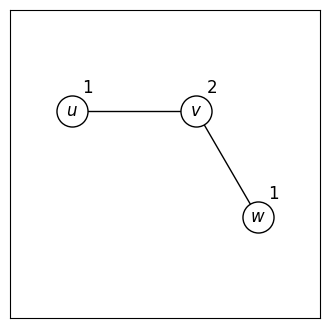

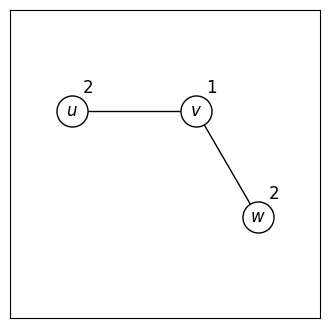

In [3]:
# Draw G1 and G2

# Create graph
G = nx.Graph()
n1 = 'u'
n2 = 'v'
n3 = 'w'
G.add_nodes_from([
    (n1, dict(name="$u$", label1="$1$", label2="$2$")),
    (n2, dict(name="$v$", label1="$2$", label2="$1$")),
    (n3, dict(name="$w$", label1="$1$", label2="$2$")),
])
G.add_edge(n1, n2)
G.add_edge(n2, n3)

# Set node positions
theta = np.pi * 60 / 180
positions = np.array([
    [-1, 0],
    [0, 0],
    [np.cos(theta), -np.sin(theta)],
])
positions *= 0.8
positions -= (positions.max(axis=0) + positions.min(axis=0))/2  # center the positions
node_pos = {
    'u': positions[0],
    'v': positions[1],
    'w': positions[2]
}

# Set label positions
label_positions = positions + np.array([0.1, 0.15])
label_pos = {
    'u': label_positions[0],
    'v': label_positions[1],
    'w': label_positions[2]
}

# Labels to display
node_names = {node: data['name'] for node, data in G.nodes(data=True)}
node_labels1 = {node: data['label1'] for node, data in G.nodes(data=True)}
node_labels2 = {node: data['label2'] for node, data in G.nodes(data=True)}

# Draw G1
plt.figure(frameon=False, figsize=(4, 4))
plt.xlim(-1,1)
plt.ylim(-1,1)
nx.draw_networkx_nodes(G, node_pos, node_size=500, node_color='white', edgecolors='black')
nx.draw_networkx_labels(G, labels=node_names, pos=node_pos)
nx.draw_networkx_labels(G, labels=node_labels1, pos=label_pos)
nx.draw_networkx_edges(G, node_pos, edgelist=G.edges())
plt.show()

# Draw G2
plt.figure(frameon=False, figsize=(4, 4))
plt.xlim(-1,1)
plt.ylim(-1,1)
nx.draw_networkx_nodes(G, node_pos, node_size=500, node_color='white', edgecolors='black')
nx.draw_networkx_labels(G, labels=node_names, pos=node_pos)
nx.draw_networkx_labels(G, labels=node_labels2, pos=label_pos)
nx.draw_networkx_edges(G, node_pos, edgelist=G.edges())
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\{'
<>:10: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\{'
<>:10: SyntaxWarning: invalid escape sequence '\{'
C:\Users\jonas\AppData\Local\Temp\ipykernel_24760\2464444753.py:9: SyntaxWarning: invalid escape sequence '\{'
  (n1, dict(name="$uv$", label1="$\\xi (\{ 1,2 \})$")),
C:\Users\jonas\AppData\Local\Temp\ipykernel_24760\2464444753.py:10: SyntaxWarning: invalid escape sequence '\{'
  (n2, dict(name="$vw$", label1="$\\xi (\{ 1,2 \})$")),


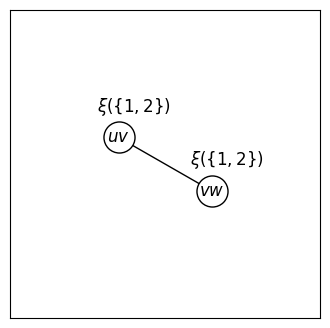

In [4]:
# Draw L(G1) and L(G2)

# Create line graph
# Create graph
LG = nx.Graph()
n1 = 'uv'
n2 = 'vw'
LG.add_nodes_from([
    (n1, dict(name="$uv$", label1="$\\xi (\{ 1,2 \})$")),
    (n2, dict(name="$vw$", label1="$\\xi (\{ 1,2 \})$")),
])
LG.add_edge(n1, n2)

# Set node positions
theta = np.pi * 60 / 180
positions = np.array([
    [-1/2, 0],
    [1/2*np.cos(theta), -1/2*np.sin(theta)],
])
positions *= 0.8
positions -= (positions.max(axis=0) + positions.min(axis=0))/2  # center the positions
node_pos = {
    'uv': positions[0],
    'vw': positions[1],
}

# Set label positions
label_positions = positions + np.array([0.1, 0.2])
label_pos = {
    'uv': label_positions[0],
    'vw': label_positions[1],
}

# Labels to display
node_names = {node: data['name'] for node, data in LG.nodes(data=True)}
node_labels1 = {node: data['label1'] for node, data in LG.nodes(data=True)}

# Draw G1
plt.figure(frameon=False, figsize=(4, 4))
plt.xlim(-1,1)
plt.ylim(-1,1)
nx.draw_networkx_nodes(LG, node_pos, node_size=500, node_color='white', edgecolors='black')
nx.draw_networkx_labels(LG, labels=node_names, pos=node_pos)
nx.draw_networkx_labels(LG, labels=node_labels1, pos=label_pos)
nx.draw_networkx_edges(LG, node_pos, edgelist=LG.edges())
plt.show()